In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

import time
import warnings
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

E:\Anaconda\envs\general\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
!pip install fuzzywuzzy

Traceback (most recent call last):
  File "E:\Anaconda\envs\general\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "E:\Anaconda\envs\general\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "E:\Anaconda\envs\general\Scripts\pip.exe\__main__.py", line 4, in <module>
ModuleNotFoundError: No module named 'pip'


In [3]:
df = pd.read_csv("G:/AIE/AIE SEM6/NLP/Project/quora-question-pairs/train.csv.zip")

In [4]:
print("Number of data points:",df.shape[0])


Number of data points: 404290


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<AxesSubplot:xlabel='is_duplicate'>

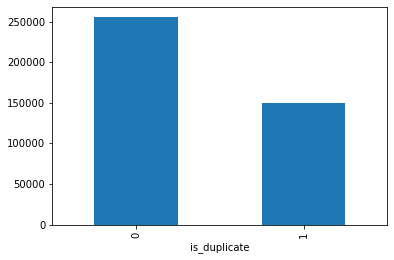

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()


In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))


~> Total number of question pairs for training:
   404290


In [8]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



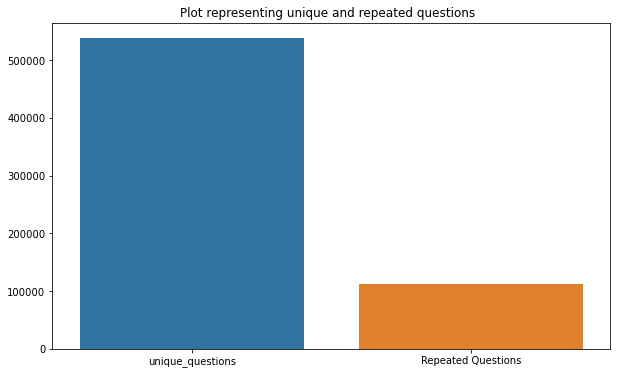

In [10]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



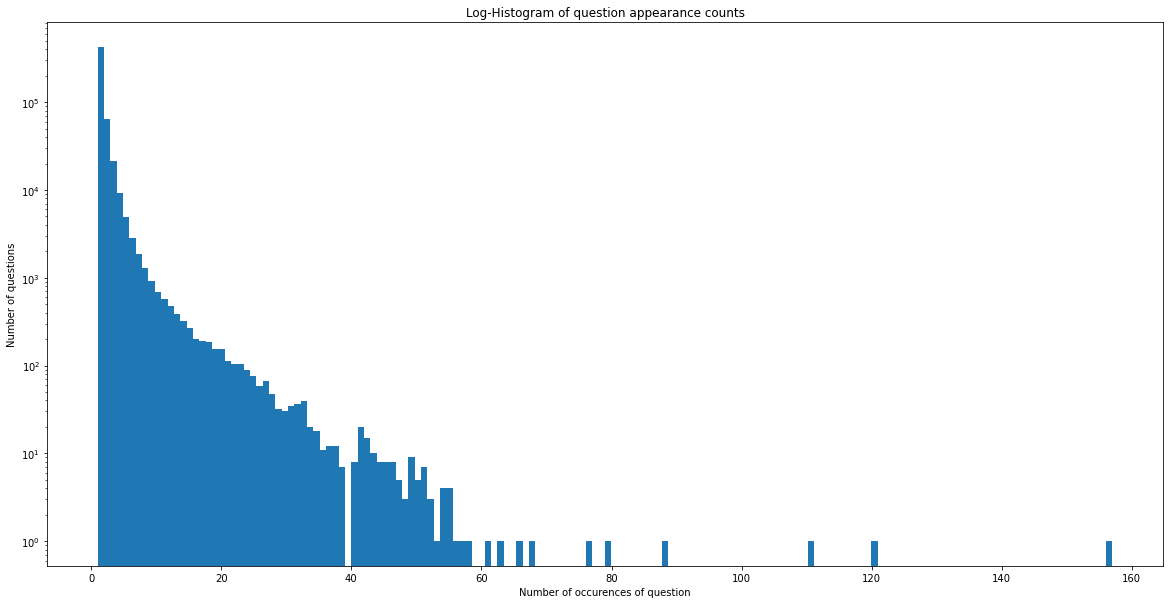

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [14]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [15]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])


df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
df_fe_without_preprocessing_train = df.copy()
df_fe_without_preprocessing_train.to_csv("df_fe_without_preprocessing_train.csv", index=False)

In [17]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


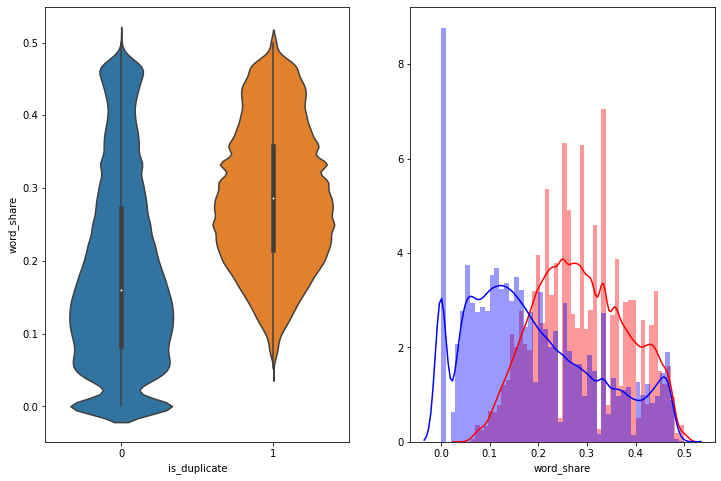

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

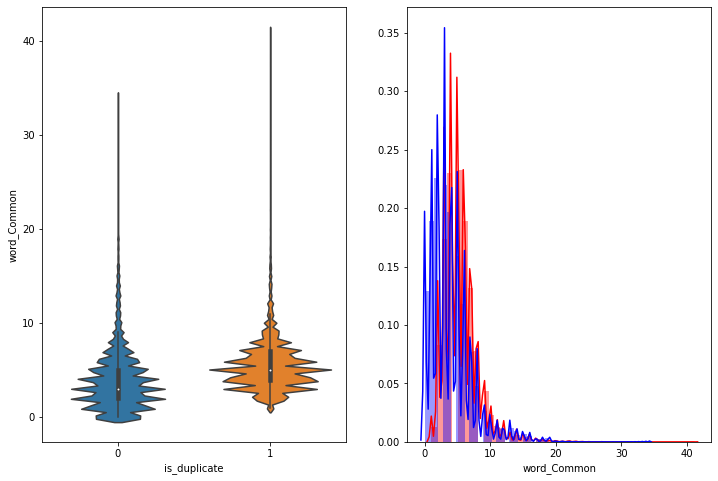

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint

In [2]:
# File paths
TRAIN_CSV = 'G:/AIE/AIE SEM6/NLP/Project/quora-question-pairs/temp.csv'
TEST_CSV = 'G:/AIE/AIE SEM6/NLP/Project/quora-question-pairs/temp.csv'
EMBEDDING_FILE = 'G:/AIE/AIE SEM6/NLP/Project/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = 'G:/AIE/AIE SEM6/NLP/Project/quora-question-pairs'

In [ ]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.key_to_index:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])
                    # Replace questions as word to question as number representation
            #dataset.set_value(index, question, q2n)
            dataset.at[index, question] = q2n
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.key_to_index:
        embeddings[index] = word2vec.get_vector(word)

del word2vec



In [ ]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [ ]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

In [ ]:
print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

In [ ]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()